<a href="https://colab.research.google.com/github/lavish315/Yes-Bank-Stock-Price-Analysis/blob/main/Capstone_project_(Yes_Bank_stock_price_analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly
#stock prices of the bank since its inception and includes closing, starting, highest, and lowest
# stock prices of every month. The main objective is to predict the stock’s closing price of the month.



##Importing all require model and library

In [1]:
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Data/Copy of data_YesBank_StockPrices.csv')

In [4]:
#Data Inspection
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [6]:
df.describe(include='all')

,Date,Open,High,Low,Close
count,185,185.000000,185.000000,185.000000,185.000000
unique,185,NaN,NaN,NaN,NaN
top,Jul-05,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,105.541405,116.104324,94.947838,105.204703
std,NaN,98.879850,106.333497,91.219415,98.583153
min,NaN,10.000000,11.240000,5.550000,9.980000
25%,NaN,33.800000,36.140000,28.510000,33.450000
50%,NaN,62.980000,72.550000,58.000000,62.540000
75%,NaN,153.000000,169.190000,138.350000,153.300000


In [7]:
# checking for duplicate rows
len(df[df.duplicated()])

0

In [8]:
numeric_features = df.columns
numeric_features

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')




### Exploratory Data Analysis







In [9]:
# setting dates as the index to the the dataframe
stock_price = df.set_index('Date')

<Axes: xlabel='Date'>

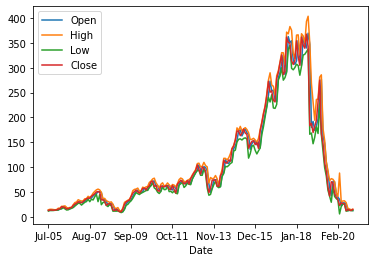

In [10]:
stock_price.plot.line()

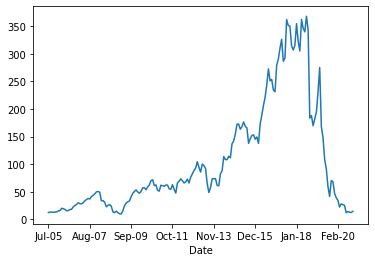

In [11]:
line= stock_price['Close'].plot.line()

In [12]:
indep_var=df[['High','Low','Open']]
dep_var=df['Close']

<Axes: xlabel='Close', ylabel='Density'>

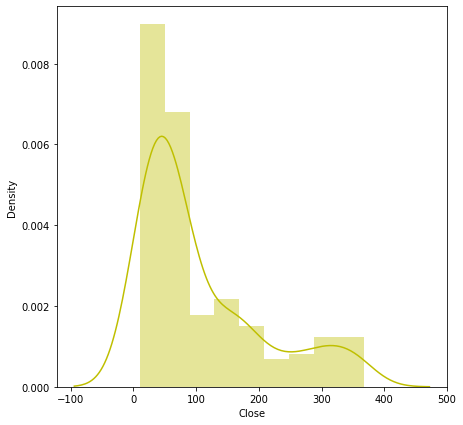

In [13]:
#Dependent variable 'close'
plt.figure(figsize=(7,7))
sns.distplot(dep_var,color="y")

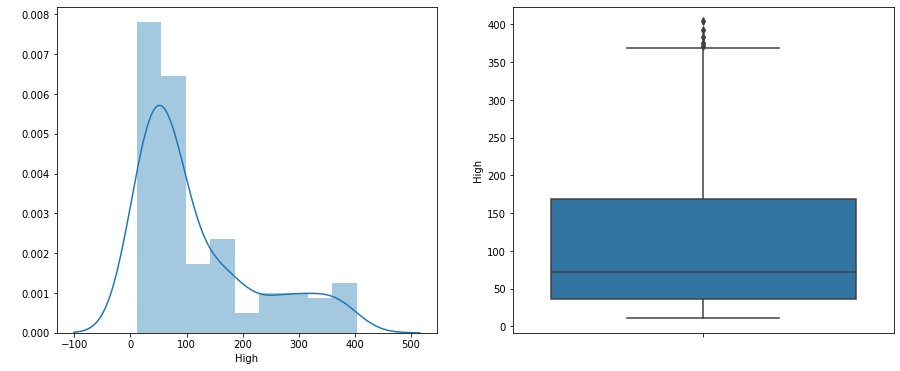

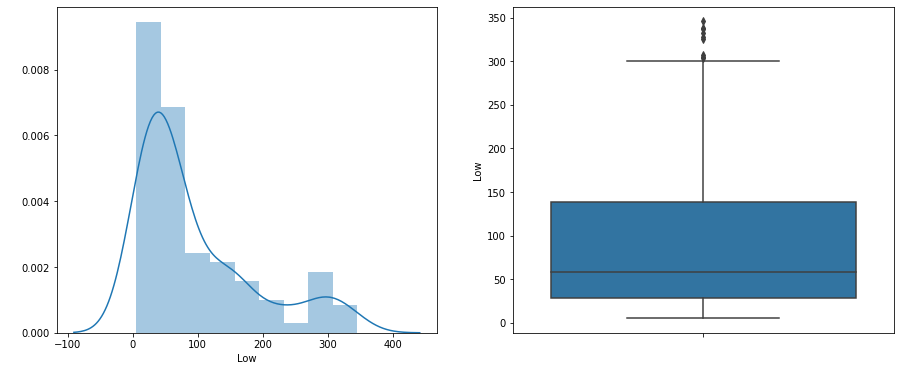

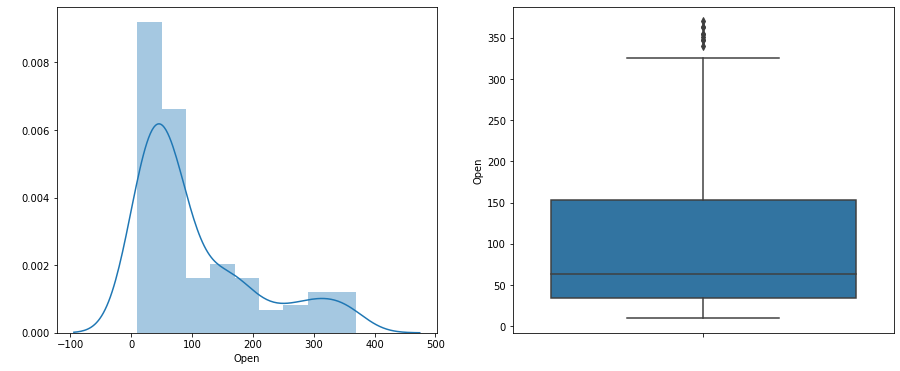

In [14]:
#plots for independent variables
for var in indep_var:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.distplot(df[var].dropna())
    fig.set_ylabel(' ')
    fig.set_xlabel(var)

    plt.subplot(1, 2, 2)
    fig = sns.boxplot(y=df[var])
    fig.set_title('')
    fig.set_ylabel(var)

# Data Transformation

Since our data is skewed, we will perform some transformations during regression analysis. Let's visualize how our data will look like post transformation.

<Axes: xlabel='Close', ylabel='Density'>

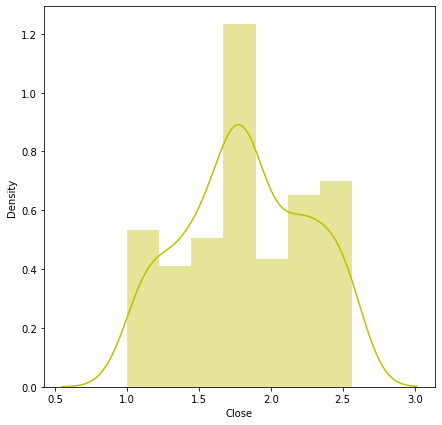

In [15]:
# Dependent variable 'Close'
plt.figure(figsize=(7,7))
sns.distplot(np.log10(dep_var),color="y")

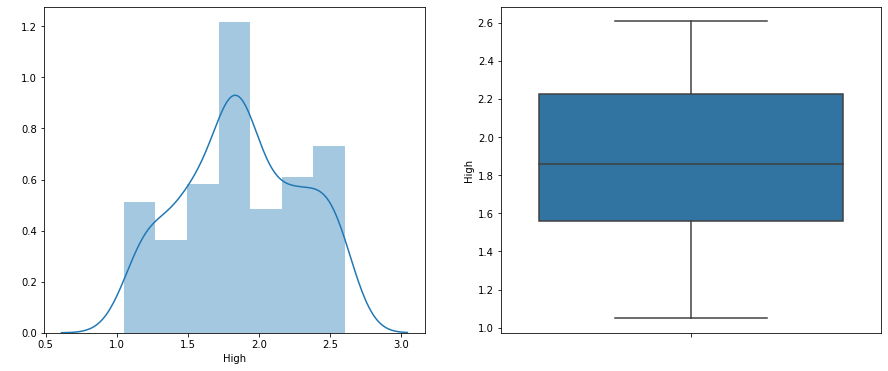

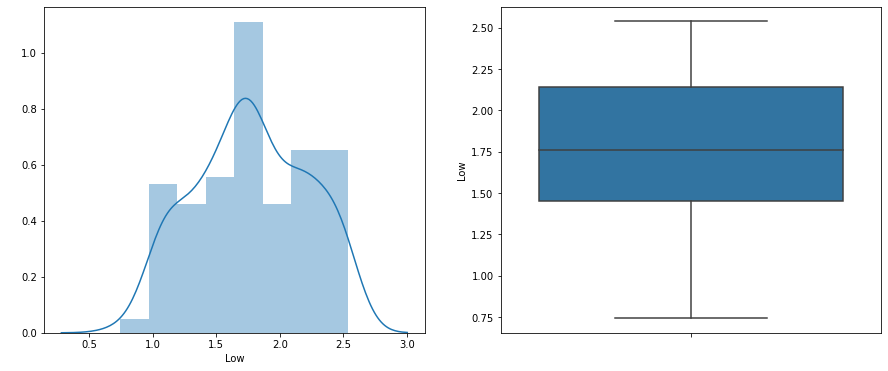

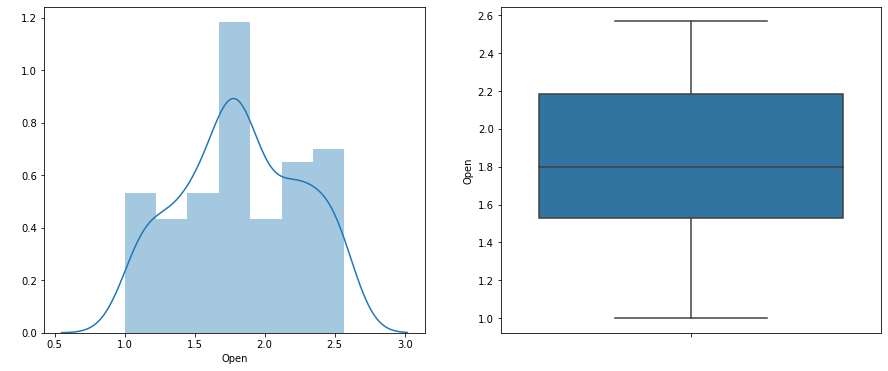

In [16]:
#independent variables
for var in indep_var:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.distplot(np.log10(df[var]))
    fig.set_ylabel(' ')
    fig.set_xlabel(var)

    plt.subplot(1, 2, 2)
    fig = sns.boxplot(y=np.log10(df[var]))
    fig.set_title('')
    fig.set_ylabel(var)

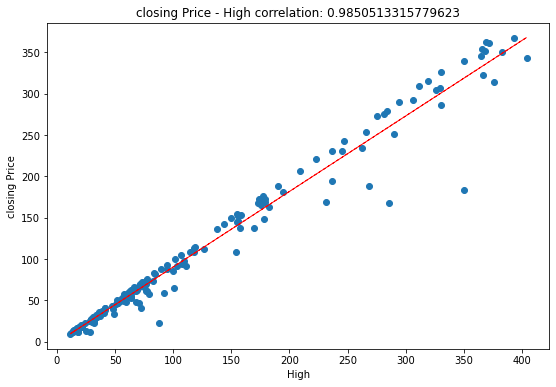

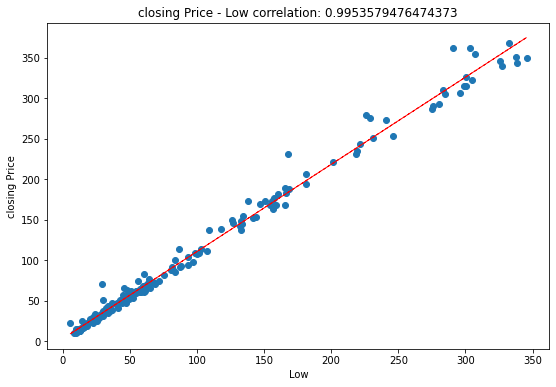

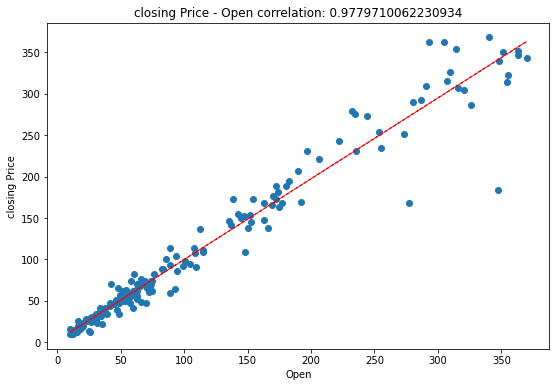

In [17]:
#scatter plot between dependent variable with all independent variables.
for col in indep_var:
   fig = plt.figure(figsize=(9, 6))
   ax = fig.gca()
   feature = df[col]
   label = df['Close']
   correlation = feature.corr(label)
   plt.scatter(x=feature, y=label)
   plt.xlabel(col)
   plt.ylabel('closing Price')
   ax.set_title('closing Price - ' + col + ' correlation: ' + str(correlation))
   z = np.polyfit(df[col], df['Close'], 1)
   y_hat = np.poly1d(z)(df[col])
 
   plt.plot(df[col], y_hat, "r--", lw=1)
 
plt.show()

CORRELATION

Now, we will see the correlation between all the features in our data set.

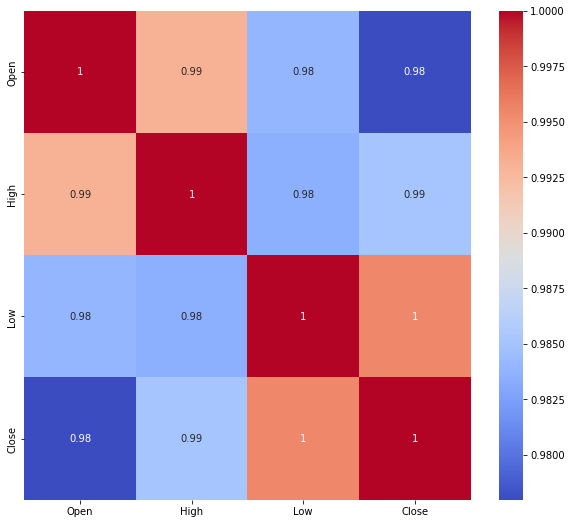

In [18]:
#correlation plot
plt.figure(figsize=(10,9))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')
plt.show()

DATAFRAME TO STORE EVALUATION METRICS

In [19]:
#empty data frame creation for evaluation metrics for each regression model into this data frame to compare at the end.
i=0
prediction_metrics=pd.DataFrame()

# Linear regression

In [20]:
dep_var = 'Close'

In [21]:
# Create a list of independent variables
indep_var = list(set(df.columns.tolist()) - {dep_var})

In [22]:
indep_var

['High', 'Low', 'Date', 'Open']

In [23]:
# Create the data of independent variables
X = df[indep_var].values

# Create the dependent variable data
y = df[dep_var].values

In [24]:
df[indep_var]

,High,Low,Date,Open
0,14.00,11.25,Jul-05,13.00
1,14.88,12.55,Aug-05,12.58
2,14.87,12.27,Sep-05,13.48
3,14.47,12.40,Oct-05,13.20
4,13.88,12.88,Nov-05,13.35
...,...,...,...,...
180,28.30,11.10,Jul-20,25.60
181,17.16,11.85,Aug-20,12.00
182,15.34,12.75,Sep-20,14.30
183,14.01,12.11,Oct-20,13.30


In [26]:
indep_var=df[['High','Low','Open']]
dep_var=df['Close']

In [27]:
#train test data split
x_train, x_test,y_train, y_test = train_test_split(indep_var,dep_var,test_size=.20,random_state=1)

In [28]:
x_train[0:5]

,High,Low,Open
59,59.90,52.60,56.7
73,63.96,50.51,62.9
120,175.58,156.45,169.0
145,368.52,337.37,363.0
118,176.96,157.80,170.0
